In [225]:
!pip install git+https://github.com/skolai/nag-gs.git

  Cloning https://github.com/skolai/nag-gs.git to /private/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/pip-req-build-1mycnglj
  Running command git clone --filter=blob:none --quiet https://github.com/skolai/nag-gs.git /private/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/pip-req-build-1mycnglj
  Resolved https://github.com/skolai/nag-gs.git to commit 095235e1657f1a67c8d145cb47d2e0e8a8d11ef4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nag-gs: filename=nag_gs-0.1.3.dev4+g095235e-py3-none-any.whl size=471146 sha256=3f70ead2d10849fa15ba8b6938565f528da82bdd134562da9edf4206e8a46808
  Stored in directory: /private/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/pip-ephem-wheel-cache-nqlprh5i/wheels/d4/c3/39/76a03b8584ca34392a282227c6b86ad2a36d9936e036b9beff
Successfully built nag-gs


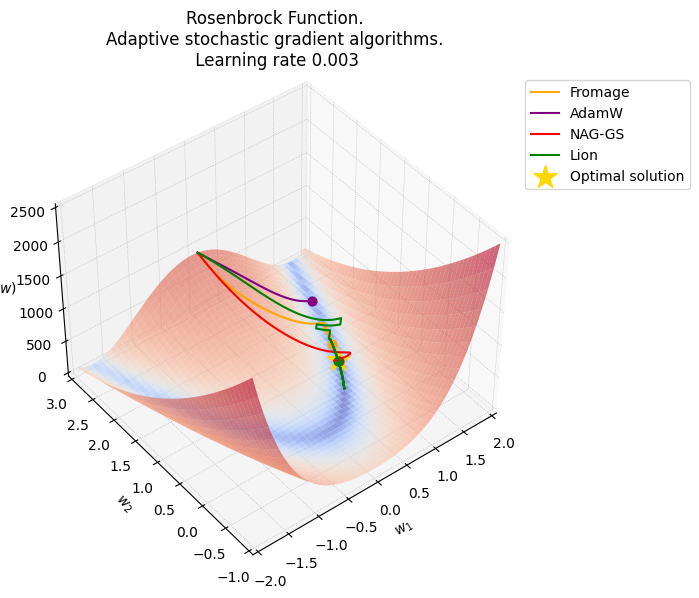

In [294]:
import jax
from jax import grad, random
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
from matplotlib.animation import FuncAnimation
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.linestyle'] = ":"
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 100
from nag_gs import nag_gs

# Rosenbrock function
def f(w):
    w1, w2 = w
    return (1 - w1)**2 + 100 * (w2 - w1**2)**2

N_ITER = 2000
total_frames = 300
LR = 3e-3  # Changed LR for better convergence in the case of Rosenbrock function
MOMENTUM = 0.9
w_0 = jnp.array([0.1, 3.0])
bounds_w_1 = (-2, 2)
bounds_w_2 = (-1, 3)

optimizers = [
    {
        'name': 'Fromage',
        'optimizer_fn': optax.fromage(LR),
        'color': 'orange'
    },
    {
        'name': 'AdamW',
        'optimizer_fn': optax.adamw(LR),
        'color': 'purple'
    },
    {
        'name': 'NAG-GS',
        'optimizer_fn': nag_gs(alpha=LR, mu=150.0, gamma=150),
        'color': 'red'
    },
    {
        'name': 'Lion',
        'optimizer_fn': optax.lion(LR),
        'color': 'green'
    }
    # You can easily add another optimizer here
]

def optimizer_trajectory(optimizer, f, w_0, n_iter=N_ITER):
    w = w_0
    g_fn = jax.jit(grad(f))
    metrics = {
        "fs": [],
        "gs": [],
        "ws": [],
    }

    state = optimizer.init(w)

    metrics["fs"].append(f(w))
    metrics["gs"].append(jnp.linalg.norm(g_fn(w)))
    metrics["ws"].append(w)

    for _ in range(n_iter):
        grads = g_fn(w)
        updates, state = optimizer.update(grads, state, w)  # Pass the current `w` here
        w = optax.apply_updates(w, updates)

        metrics["fs"].append(f(w))
        metrics["gs"].append(jnp.linalg.norm(g_fn(w)))
        metrics["ws"].append(w)

    return metrics

metrics = {}
for opt in optimizers:
    metrics[opt['name']] = optimizer_trajectory(opt['optimizer_fn'], f, w_0)

# Set up the 3D plot
fig, axl = plt.subplots(subplot_kw=dict(projection='3d', azim=-128.0, elev=43.0, computed_zorder=False), figsize=(8, 6))

x = jnp.linspace(*bounds_w_1, 50)
y = jnp.linspace(*bounds_w_2, 50)
X, Y = jnp.meshgrid(x, y)
Z = jnp.array([f(jnp.array([x_, y_])) for x_, y_ in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
axl.plot_surface(X, Y, Z, alpha=0.6, cmap='coolwarm', norm=LogNorm())
axl.set_xlabel(r'$w_1$')
axl.set_ylabel(r'$w_2$')
axl.set_xlim(bounds_w_1)
axl.set_ylim(bounds_w_2)
axl.set_zlim([0, 2500])
axl.zaxis.set_rotate_label(False)
axl.set_zlabel(r'$f(w)$', rotation=0)
axl.set_title(f'Rosenbrock Function.\nAdaptive stochastic gradient algorithms.\n Learning rate {LR}')

# Initial trajectories as empty lines
lines = []
for opt in optimizers:
    line, = axl.plot([], [], [], color=opt['color'], label=opt['name'])
    lines.append(line)


# In the 'Set up the 3D plot' section, after plotting the surface and setting labels:
global_min = (1, 1)
axl.scatter(global_min[0], global_min[1], f(jnp.array(global_min)), color='gold', marker='*', s=300, label='Optimal solution')

axl.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Define the animation function
last_scatters = []

def animate(i):
    global last_scatters, total_frames, N_ITER
    axl.view_init(azim=-128.0, elev=43.0)

    skip_rate = int(jnp.floor(N_ITER/total_frames))
    max_trajectory_length = 2500
    
    # Remove the previous scatter points
    for scatter in last_scatters:
        scatter.remove()
    last_scatters = []

    for opt, line in zip(optimizers, lines):
        w_trajectory = jnp.array(metrics[opt['name']]["ws"][:i*skip_rate+1])
        if len(w_trajectory[:, 0]) > max_trajectory_length:
            select_points = jnp.linspace(1, len(w_trajectory[:, 0]), max_trajectory_length).astype(int)
            line.set_data(w_trajectory[select_points, 0], w_trajectory[select_points, 1])
            line.set_3d_properties([f(w) for w in w_trajectory[select_points]])
        else:
            line.set_data(w_trajectory[:, 0], w_trajectory[:, 1])
            line.set_3d_properties([f(w) for w in w_trajectory])

        # Current point
        w_current = metrics[opt['name']]["ws"][i*skip_rate]
        scatter = axl.scatter(w_current[0], w_current[1], f(w_current), color=opt['color'], s=40)
        last_scatters.append(scatter)

    return lines

# Animate the plots
ani = FuncAnimation(
    fig,
    animate,
    interval=1000/30,  # Increased interval for clearer visualization
    frames=total_frames
)

animate(total_frames)
fig.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


In [291]:
# This took about 6 minutes on Macbook Pro with M1 Pro
ani.save('video.mp4',fps=30, dpi=500)

In [295]:
# This took about 6 minutes on Macbook Pro with M1 Pro
video = ani.to_html5_video()

In [296]:
from IPython import display
html = display.HTML(video)
display.display(html)
# plt.close()